In [5]:
#quick prototyping on using GPs to learn policies and all this jazz.
#what is the real point of planning? The point is surely to approximate by sampling the immediate and local action-value function
#likely through means of approximating the POLICY VALUE FUNCTION, or alternatively approximating the policy value function directly... i.e .the value obtained 
#in policy space where we just have a couple of action policies. Ultimately though we want an action value function... or perhaps not depending on what you have
# but what the point is is to have multiple exploration bounds right. The WHOLE POINT of planning is exploration of the space at least in an MPC framework.
# the current methods do what is effectively random exploration or, in the case of CEM do anti exploraiton on epochs. But the point is only to explore where it might be most valuable
# which I guess is the point of CEM. the point is you NEED to be able to do better. The okada paper from what I can tell is just basically doing maximum entropy exploration during poliy space
#but this is potentially a silly thing. Additionally, the planner will give your actor very effective deep information perhaps than that gleaned merely from transitions.
# first aim is to estimate from samples just what the action value function looks like for some simple cases, to see if I can use it at all.
#to see if there is valuable intuition, but it's generally pretty shocking how BAD the current SOTA in planning is. My goals with this project (which is fairly long term) is therefore to put
#variational planning on proper comprehensive mathematical foundation and 2.) develop better planning algs. So let's start playing.

!pip install git+https://github.com/Bmillidgework/exploration-baselines
!pip install box2d-py

  Cloning https://github.com/Bmillidgework/exploration-baselines to /tmp/pip-req-build-s3n618mu
  Running command git clone -q https://github.com/Bmillidgework/exploration-baselines /tmp/pip-req-build-s3n618mu
  Created wheel for baselines: filename=baselines-1.0.0-cp36-none-any.whl size=55652 sha256=5224939ddac6433fcc78a3f1046f1004c1d453b451f3eb75dec8f91e539f568b
  Stored in directory: /tmp/pip-ephem-wheel-cache-onkw3q5s/wheels/ba/59/01/a1063d40b0ecb5bae01453828562c4ce3437825193933e8abc
Successfully built baselines
     |████████████████████████████████| 450kB 4.9MB/s 


In [0]:

import numpy as np
import torch
import torch.nn as nn
from copy import deepcopy
### Random shooting planner ###
# Just samples a bunch of trajectories at random and picks the best one.

class RandomShootingPlanner(nn.Module):
    def __init__(self, env,
    plan_horizon,
    N_samples,
    action_noise_sigma,
    discount_factor=1,
    save_states = False,
    save_actions=False,
    save_rewards = False,
    device='cpu'):
        super().__init__()
        self.env = deepcopy(env)
        self.action_size = env.action_space.shape[0]
        self.plan_horizon = plan_horizon
        self.N_samples = N_samples
        self.action_noise_sigma = action_noise_sigma
        self.discount_factor = discount_factor
        self.save_states = save_states
        self.save_actions = save_actions
        self.save_rewards = save_rewards
        self.device=device
        if self.discount_factor <1:
            self.discount_factor_matrix = self._initialize_discount_factor_matrix()
        else:
            self.discount_factor_matrix = np.ones([self.plan_horizon,1])

        if self.save_states:
            self.states = []
        if self.save_actions:
            self.actions = []
        if self.save_rewards:
          self.rewards =[]

    def _initialize_discount_factor_matrix(self):
        discounts = np.zeros([self.plan_horizon,1])
        for t in range(self.plan_horizon):
            discounts[t,:] = self.discount_factor ** self.plan_horizon
        #discounts=torch.from_numpy(discounts).repeat(1, self.N_samples, 1).to(self.device)
        return discounts

    def forward(self, state):
        self.state_size = state.shape[0]
        state = torch.from_numpy(state)
        state = state.unsqueeze(dim=0)
        state = state.repeat(self.N_samples,1)

        action_mean = torch.zeros(self.plan_horizon, 1, self.action_size).to(
            self.device
        )
        action_std_dev = torch.ones(self.plan_horizon, 1, self.action_size).to(
            self.device
        )
        actions = action_mean + action_std_dev * torch.randn(
            self.plan_horizon,
            self.N_samples,
            self.action_size,
            device=self.device,
        )

        #full rewards
        rewards = self.perform_rollout(state, actions)
        #print("rollout complete: ", rewards.size())
        #sum across timesteps
        rewards = rewards.sum(dim=1)
        #print("REWARDS: ", rewards)
        #print("MAX:", torch.max(rewards))
        #find best trajectory
        best_idx =torch.argmax(rewards).item()
        best_action_trajectory = actions[:,best_idx,:]
        best_action = best_action_trajectory[0,:]
        return best_action.numpy()


    def perform_rollout(self,current_state, actions):
        current_state = current_state.cpu()
        actions = actions.cpu()
        returns = torch.zeros([self.N_samples,self.plan_horizon])
        for k in range(self.N_samples):
            s = self.env.reset()

            self.env._env.state = self.env._env.state_from_obs(current_state[0,:].numpy())
            state_list = []
            action_list = []
            reward_list = []
            for t in range(self.plan_horizon):
                action = actions[t,k,:].numpy()
                s, reward, _ = self.env.step(action)
                if self.save_states:
                    state_list.append(s)
                if self.save_actions:
                    action_list.append(action)
                if self.save_rewards:
                  reward_list.append(reward)
                returns[k,t] = reward * self.discount_factor_matrix[t,:][0]

            self.states.append(np.array(state_list))
            self.actions.append(np.array(action_list))
            self.rewards.append(np.array(reward_list))
        return returns


In [32]:

import gym
import matplotlib.pyplot as plt
from baselines.envs import TorchEnv, const

env = TorchEnv("pendulum",200)
planner = RandomShootingPlanner(env,
         plan_horizon=30,
         N_samples=1000,
         action_noise_sigma=1,
         discount_factor = 0.9,
         save_states = True,
         save_actions = True,
         save_rewards = True)

s = env.reset()
a = planner(s)
print(a)


/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[-0.63669735]


Reward:  -1.4363925550609977


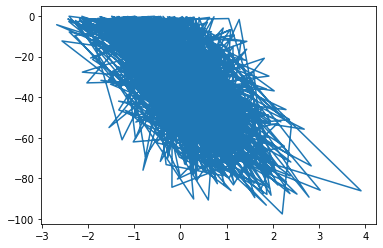

Reward:  -0.010867331251553349


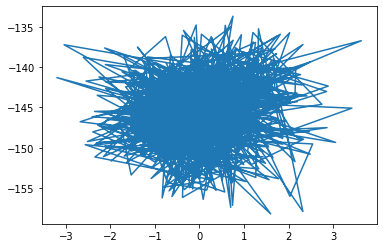

Reward:  -5.731271750716011


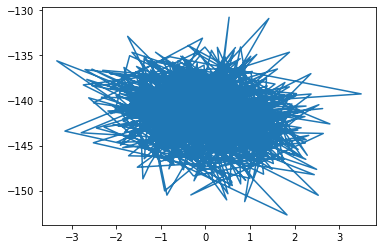

Reward:  -5.447717194945361


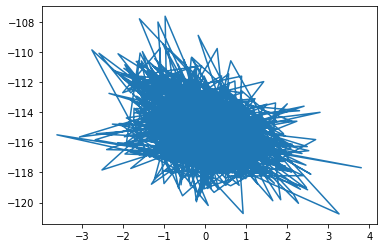

Reward:  -0.43654611839452584


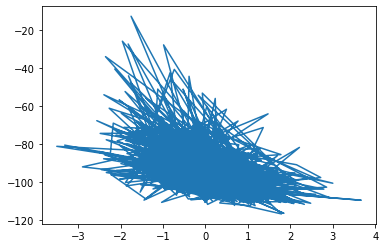

Reward:  -0.07800666099239369


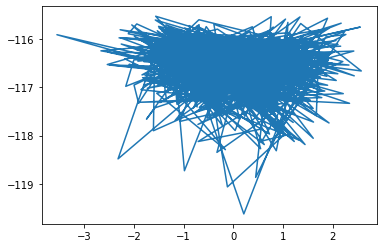

Reward:  -1.3764110341118698


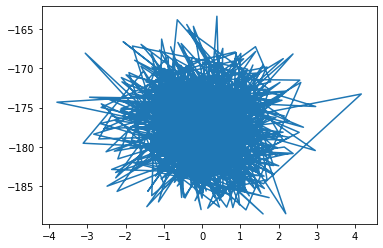

Reward:  -8.421639505042537


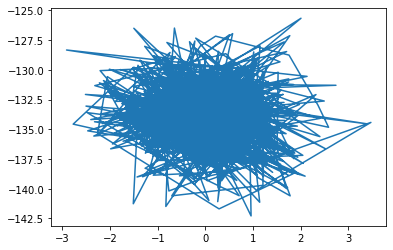

Reward:  -4.72225063284142


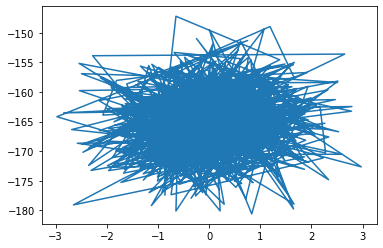

Reward:  -7.730206862424611


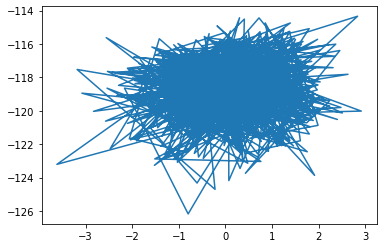

Reward:  -2.5441380902895103


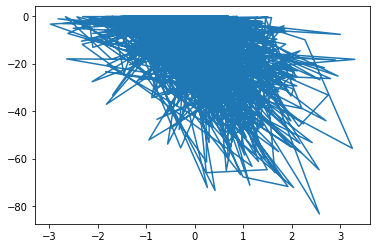

Reward:  -0.017863641983126795


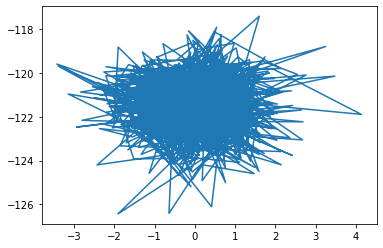

Reward:  -3.0673362111644376


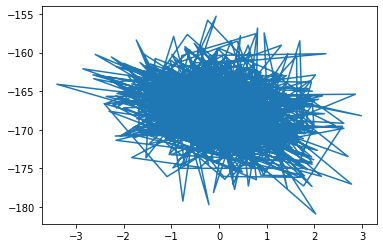

Reward:  -7.802485595842261


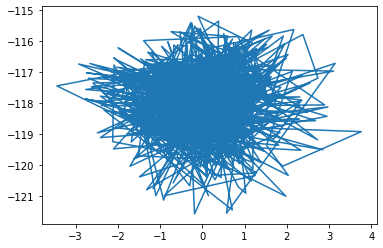

Reward:  -2.1859265872968443


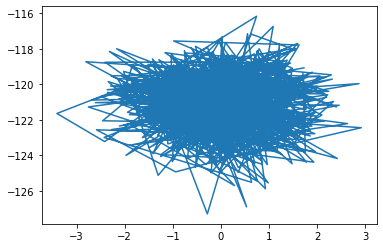

Reward:  -2.9024911057325324


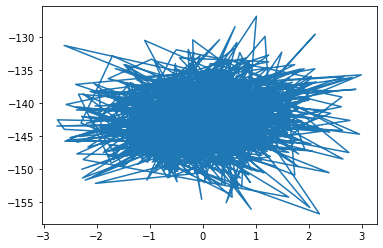

Reward:  -5.565497776055482


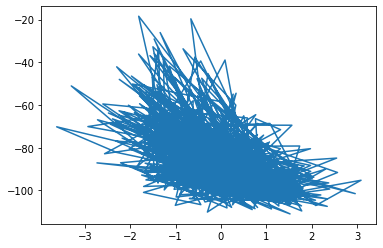

Reward:  -0.2023750185984991


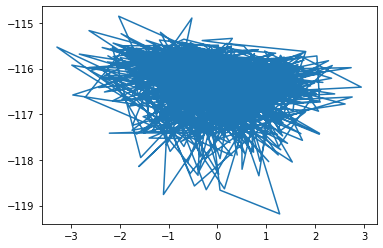

Reward:  -1.1959876649520849


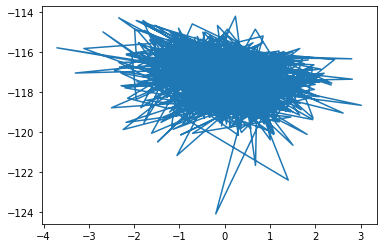

Reward:  -0.7234424336932316


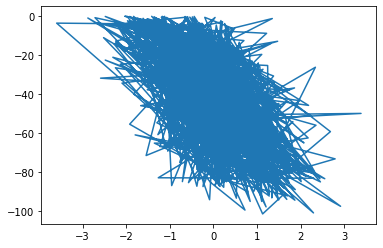

Reward:  -0.03155912303469205


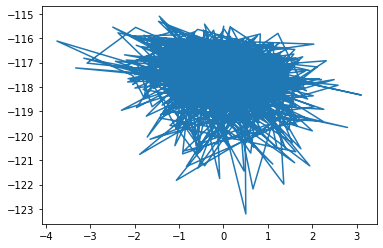

Reward:  -0.7686741385638086


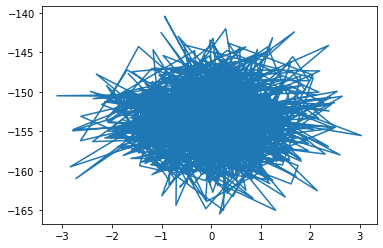

Reward:  -6.434275716891689


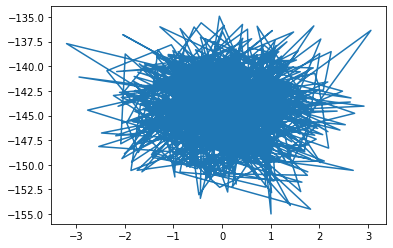

Reward:  -5.626851466276261


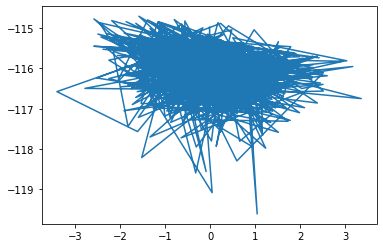

Reward:  -1.4083367989406377


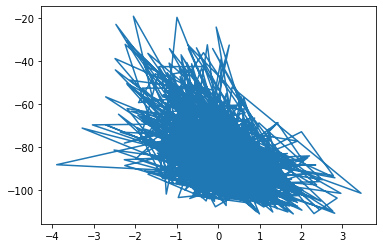

Reward:  -0.08333505839586446


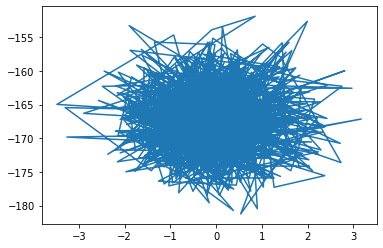

Reward:  -7.604712718017073


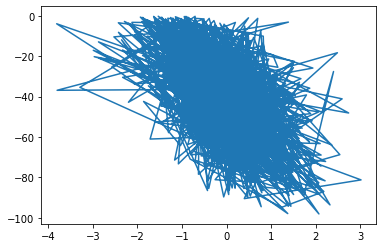

Reward:  -0.017856586457923283


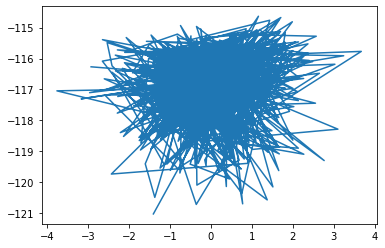

Reward:  -2.0231885055918624


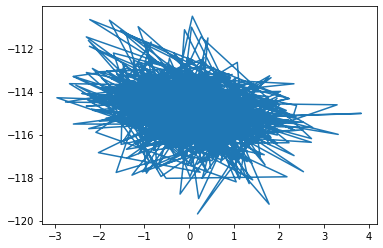

Reward:  -1.1630068696320506


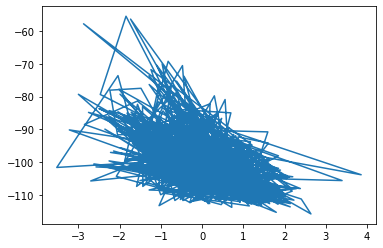

Reward:  -0.20960280194073502


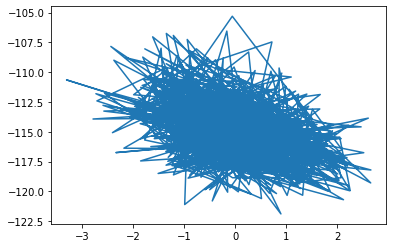

Reward:  -0.2976438522003638


KeyboardInterrupt: ignored

In [33]:
# now let's investigate the shape of the action distribution over action 1 that is learned.

def plot_action_value(planner):
  planner.rewards = []
  planner.actions = []
  s = env.reset()
  a = planner(s)
  rlist = np.array(planner.rewards)
  alist = np.array(planner.actions)
  a_s = alist[:,0,0]
  #print(alist.shape)
  #print(rlist.shape)
  plt.plot(a_s,np.sum(rlist,axis=1))
  plt.show()
# so we know for sure that this is a pretty damn multimodal function, which I guess is nice to know. Let's plot this to see how it evolves over time
# that's cool. So that gives us a very weird kind of uniform ball function. Which is really nice with some spikes. Let's see how this changes a bit.
# the issue here is that this function is pretty damn useless. Let's plot a bunch of these as control is applied so I can see what's going on
# it's strange though that the random shooting planner doesn't seem to be able to solve the task, which is a bit annoying and worrisome! this is going to be really hard to figure out overall, I think.


s = env.reset()
for i in range(100):
  a = planner(s)
  s,r,done = env.step(a)
  print("Reward: ",r)
  plot_action_value(planner)